# ALPHA SCRIPT

This script combines all the steps so that it runs automatically

In [1]:
import os
import io
import json
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shutil
from glob import glob
from noisi.util.setup_data_gaussgrid import setup_data_gaussgrid
from noisi.scripts.source_grid_gauss import gauss_grid
from noisi.util.setup_noisesource_new import setup_noisesource_new
from noisi.util.plot_with_azimuth_sel import plot_section
from noisi.util.make_synthetic_data import make_synth_data
from noisi.util.plot_cartopy import plot_gradient

main_path = os.getcwd()
print(main_path)

NOISI toolkit
Python version: 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:44:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
mpi4py version: 3.0.0
/Users/jigel/noisi/noisi
/Users/jigel/noisi


{	
    'n_cores': 8,
    'project_name': "TEST_Project",
    'data_path': "./WW3-GLOB-30M_201701_p2l.nc",
    't_data': 72,
    'f_dom': 1/10,
    'data_thresh': 0.04,
    'gamma_thresh': 8,
    'extent': [-90,90,0,90],
   
    'gamma_const': 3,
    'back_grid_phi': 4,
    'data_grid_phi': 0.4,

    'stationlist_path': "./stationlist_atlantic_26.csv",

    'wavefield_path': "../axisem/SOLVER/Noisi_10s_repacked/"
}



In [16]:
# First step: Input
# Make a config file for this

# number of cores
n_cores = 8

project_name = "TEST_Project"

# data input
data_path = os.path.abspath("./WW3-GLOB-30M_201701_p2l.nc")
t_data = 72
f_dom = 1/10
data_thresh = 0.04
gamma_thresh = 8
extent = [-90,90,0,90]

# grid input
gamma_const = 3
back_grid_phi = 4
data_grid_phi = 0.4

# station list input
stationlist_path = os.path.abspath("./stationlist_atlantic_26.csv")

# wavefield input
wavefield_path = os.path.abspath("../axisem/SOLVER/Noisi_10s_repacked/")

# write to alpha_config.json file
with io.open('./alpha_config.json','r+') as fh:
    conf = json.loads(fh.read())
        
conf['n_cores'] = n_cores    
conf['project_name'] = project_name
conf['data_path'] = data_path
conf['t_data'] = t_data
conf['f_dom'] = f_dom
conf['data_thresh'] = data_thresh
conf['gamma_thresh'] = gamma_thresh
conf['extent'] = extent
conf['gamma_const'] = gamma_const
conf['back_grid_phi'] = back_grid_phi
conf['data_grid_phi'] = data_grid_phi
conf['stationlist_path'] = stationlist_path
conf['wavefield_path'] = wavefield_path

with io.open('./alpha_config.json','w') as fh:
    cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
    fh.write(cf)

In [19]:
with io.open('./alpha_config.json','r') as fh:
    alpha_config = json.load(fh)
    
print(alpha_config)

{'n_cores': 8, 'project_name': 'TEST_Project', 'data_path': '/Users/jigel/noisi/WW3-GLOB-30M_201701_p2l.nc', 't_data': 72, 'f_dom': 0.1, 'data_thresh': 0.04, 'gamma_thresh': 8, 'extent': [-90, 90, 0, 90], 'gamma_const': 3, 'back_grid_phi': 4, 'data_grid_phi': 0.4, 'stationlist_path': '/Users/jigel/noisi/stationlist_atlantic_26.csv', 'wavefield_path': '/Users/jigel/axisem/SOLVER/Noisi_10s_repacked'}


In [3]:
# Setup new project
os.system('noisi setup_project ' + project_name)
print('New project created:', project_name)

project_path = os.path.join(main_path,project_name)
print('Path to new project: ', project_path)

# copy stationlist file to project and rename stationlist.csv
os.system ('cp {} {}'.format(stationlist_path,os.path.join(project_path,'stationlist.csv')))
print ('Copied stationlist file to project directory.')

# Change current directory to project directory
os.chdir(project_path)
print('Changed to project directory:',os.getcwd())

New project created: TEST_Project
Path to new project:  /Users/jigel/noisi/TEST_Project
Copied stationlist file to project directory.
Changed to project directory: /Users/jigel/noisi/TEST_Project


In [8]:
# Setup the grid
# Need to make variables for how dense additional grids are

sigma,beta,phi_ini,phi_max,lat_0,lon_0,n,gamma = setup_data_gaussgrid(project_path,data_path,t_data,f_dom,data_thresh,gamma_thresh,gamma_const,back_grid_phi,data_grid_phi,extent,plot=False)

plot = False
only_ocean = True
dense_antipole = False

# Adjust so it can be written to config file
lat_0 = [float(i) for i in lat_0]
lon_0 = [float(i) for i in lon_0]

# Write to config.json file
config_path = os.path.join(project_path,'config.json')


with io.open(config_path,'r+') as fh:
        conf = json.loads(fh.read())
        
conf['gauss_grid'] = True      
conf['gauss_sigma'] = sigma
conf['gauss_beta'] = beta
conf['gauss_phi_ini'] = phi_ini
conf['gauss_phi_max'] = phi_max
conf['gauss_lat_0'] = lat_0
conf['gauss_lon_0'] = lon_0
conf['gauss_n'] = n
conf['gauss_gamma'] = gamma
conf['gauss_plot'] = plot
conf['gauss_dense_antipole'] = dense_antipole
conf['gauss_only_ocean'] = only_ocean

# Set below to true if voronoi cell surface area is to be calculated
conf['voronoi_surface_area'] = True

# change instaseis and wavefield
conf['instaseis'] = True
conf['wavefield_path'] = os.path.abspath(wavefield_path)

with io.open(config_path,'w') as fh:
    cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
    fh.write(cf)

    


NameError: name 'project_path' is not defined

In [28]:
# calculate grid with noisi
print('Computing grid...')
os.system('noisi setup_sourcegrid .')
print('Grid computed and saved as sourcegrid.npy')

Computing grid...
Grid computed and saved as sourcegrid.npy


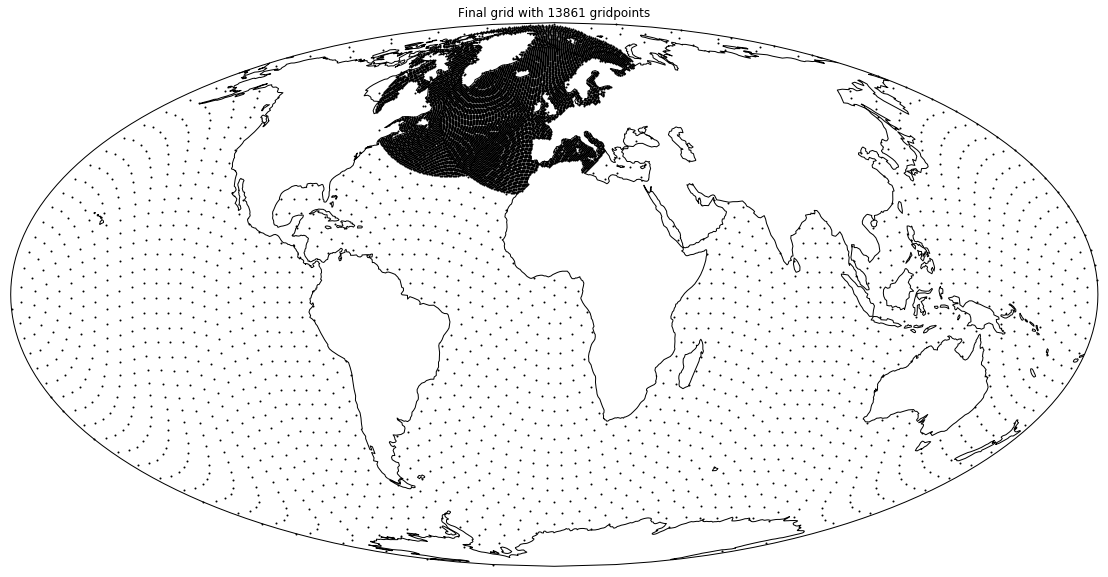

In [29]:
# Plot and save sourcegrid
sourcegrid_path = os.path.join(project_path,'sourcegrid.npy')
grid = np.load(sourcegrid_path)

plt.figure(figsize=(25,10))
ax = plt.axes(projection=ccrs.Mollweide())
ax.coastlines()
plt.scatter(grid[0],grid[1],s=1,c='k',transform=ccrs.Geodetic())
plt.title('Final grid with {} gridpoints'.format(np.size(grid[0])))
plt.savefig(os.path.join(project_path,"sourcegrid.png"))
plt.show()

In [30]:
# Setup a homogeneous source called homo_source
source_homo = "homo_source"

source_homo_path = os.path.join(project_path,source_homo)
os.system ('noisi setup_source ' + source_homo_path)

print('New source created: ', source_homo_path)

New source created:  /Users/jigel/noisi/TEST_Project/homo_source


In [18]:
# Get number of stations for mpi
stationlist = read_csv(stationlist_path)
station_n = np.shape(stationlist)[0]
print('Number of stations: ',station_n)

Number of stations:  26


In [9]:
# Convert wavefield 
# need arguments: source_config, config, sourcegrid, stationlist, output folder

source_config_path = os.path.join(source_homo_path,'source_config.json')
wavefield_from_instaseis_path = os.path.join(source_homo_path,'wavefield_from_instaseis.py')

print('Converting wavefield from instaseis...')
os.system('mpirun -np {} python {} {} {} {} {} {}'.format(station_n,wavefield_from_instaseis_path,source_config_path,config_path,sourcegrid_path,stationlist_path,project_path))
print('Done.')

Converting wavefield from instaseis...
Done.


In [10]:
wavefield_processed_path = os.path.join(project_path,'wavefield_processed')

# Change config.json file
with io.open(config_path,'r+') as fh:
        conf = json.loads(fh.read())

# change instaseis and wavefield
conf['instaseis'] = False
conf['wavefield_path'] = os.path.abspath(wavefield_processed_path)

with io.open(config_path,'w') as fh:
    cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
    fh.write(cf)

In [11]:
# Change source_config file
source_config_path = os.path.join(source_homo_path,'source_config.json')

with io.open(source_config_path,'r+') as fh:
        conf = json.loads(fh.read())

# change instaseis and wavefield
conf['max_lag'] = 2500
conf['preprocess_do'] = False
conf ['project_name'] = project_name
conf ['project_path'] = project_path
with io.open(source_config_path,'w') as fh:
    cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
    fh.write(cf)

Setting up noisesource distribution...
Number of gridpoints:  13861
<HDF5 file "UP.ROTU..MXZ.h5" (mode r)>
df = 1.0 nt =  4953 n =  10000
freq_min =  0.0 freq_max =  0.5
Getting ocean mask...
Latitude from -88.0 to 88.0,
        Longitude from -180.0 to 180.0


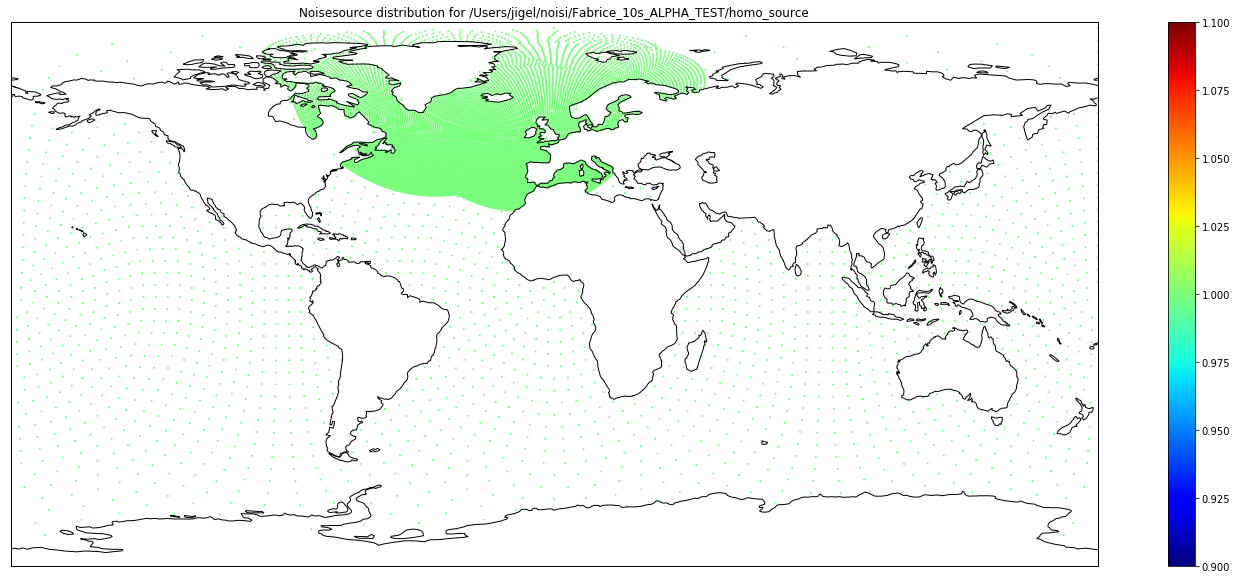

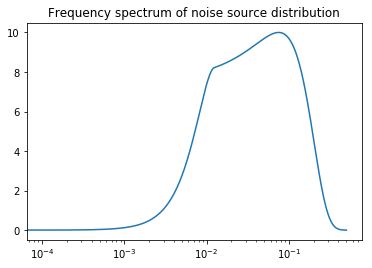

Number of grids:  5
Grid 1 of 5
Grid 2 of 5
Grid 3 of 5
Grid 4 of 5
Grid 5 of 5
0 of 21553 voronoi cell surface areas calculated.
1000 of 21553 voronoi cell surface areas calculated.
2000 of 21553 voronoi cell surface areas calculated.
3000 of 21553 voronoi cell surface areas calculated.
4000 of 21553 voronoi cell surface areas calculated.
5000 of 21553 voronoi cell surface areas calculated.
6000 of 21553 voronoi cell surface areas calculated.
7000 of 21553 voronoi cell surface areas calculated.
8000 of 21553 voronoi cell surface areas calculated.
9000 of 21553 voronoi cell surface areas calculated.
10000 of 21553 voronoi cell surface areas calculated.
11000 of 21553 voronoi cell surface areas calculated.
12000 of 21553 voronoi cell surface areas calculated.
13000 of 21553 voronoi cell surface areas calculated.
14000 of 21553 voronoi cell surface areas calculated.
15000 of 21553 voronoi cell surface areas calculated.
16000 of 21553 voronoi cell surface areas calculated.
17000 of 21553 

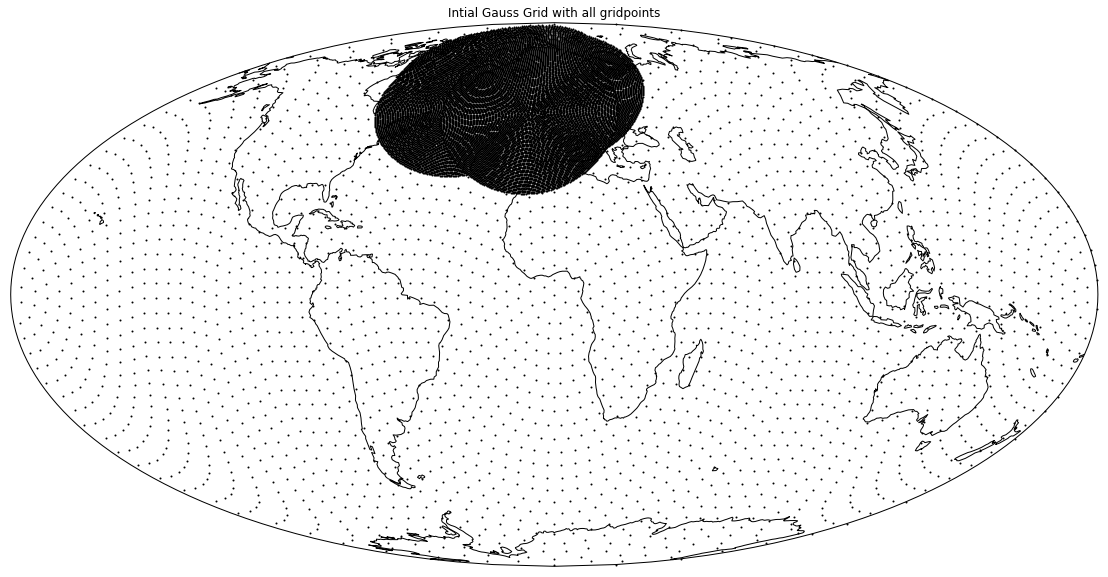

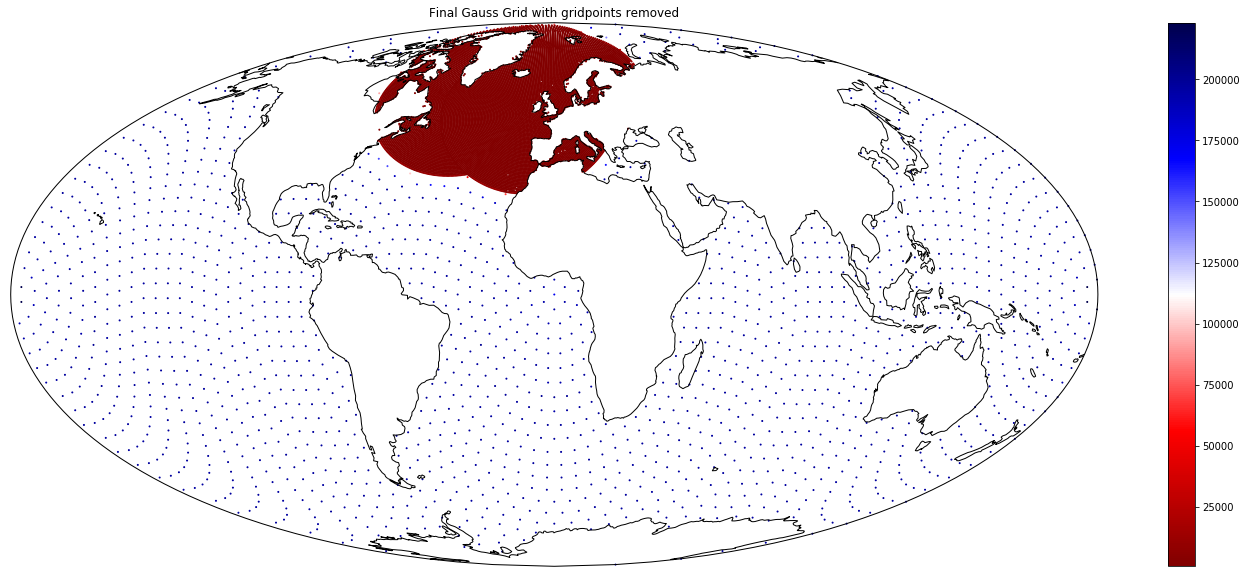

Gridpoints and voronoi cells on land removed.
Final number of gridpoints: 13861
Done.


In [12]:
# setup noise source for homogeneous model

print('Setting up noisesource distribution...')
setup_noisesource_new(project_path,source_homo_path)
print('Done.')

In [13]:
# calculate correlations for homogeneous source
print("Computing correlations...")
os.system("mpirun -np {} noisi correlation {} {}".format(n_cores,source_homo_path,0))
print("All correlations computed.")

Computing correlations...
All correlations computed.


/Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/homo_source/step_0/corr
Found traces:

/Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/homo_source/step_0/corr/GB.CWF..MXZ--GE.VAL..MXZ.sac
...to...
/Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/homo_source/step_0/corr/DK.MUD..MXZ--NS.FOO..MXZ.sac
Assign geographical information.

CWF VAL
52.7383 -1.30722 51.9394 -10.2442
UDBI UDBI
44.5279 15.7644 44.5279 15.7644
BIGH CWF
58.4933 -3.9105 52.7383 -1.30722
FRB SFJD
63.7469 -68.5451 66.9961 -50.62076
DRUM CLL
56.9126 -2.4865 51.30769 13.00261
CWF SOFL
52.7383 -1.30722 62.0689 -6.9658
MONQ VAL
44.3676 1.1953 51.9394 -10.2442
GIMEL BSEG
46.533640000000005 6.26545 53.93531 10.316889999999999
FUORN BIGH
46.62022 10.26352 58.4933 -3.9105
UDBI ISKR
44.5279 15.7644 64.559998 -18.385998999999998
FUORN FUORN
46.62022 10.26352 46.62022 10.26352
SFJD FOO
66.9961 -50.62076 61.598 5.044
CLF CLL
48.02581 2.26 51.30769 13.00261
FOO NSS
61.598 5.044 64.53 11.967
SOFL ISKR
62.0689 -6.9658 64.559998 -18.385998999999998
GIMEL

CLF IVI
48.02581 2.26 61.205808 -48.171178000000005
FRB FUR
63.7469 -68.5451 48.1655 11.27633
MONQ JMIC
44.3676 1.1953 70.9866 -8.5057
EKSU EKSU
57.5726 15.3016 57.5726 15.3016
MUD VAL
56.455 9.17331 51.9394 -10.2442
CLL JMIC
51.30769 13.00261 70.9866 -8.5057
GIMEL SOFL
46.533640000000005 6.26545 62.0689 -6.9658
CWF BSEG
52.7383 -1.30722 53.93531 10.316889999999999
CLL EKSU
51.30769 13.00261 57.5726 15.3016
SOFL VAL
62.0689 -6.9658 51.9394 -10.2442
CWF SFJD
52.7383 -1.30722 66.9961 -50.62076
FRB CWF
63.7469 -68.5451 52.7383 -1.30722
GIMEL CLF
46.533640000000005 6.26545 48.02581 2.26
UDBI FOO
44.5279 15.7644 61.598 5.044
IVI ISKR
61.205808 -48.171178000000005 64.559998 -18.385998999999998
FRB SOFL
63.7469 -68.5451 62.0689 -6.9658
VAL CLL
51.9394 -10.2442 51.30769 13.00261
FUORN MUD
46.62022 10.26352 56.455 9.17331
FUORN JSA
46.62022 10.26352 49.1879 -2.17089
SFJD SFJD
66.9961 -50.62076 66.9961 -50.62076
FUORN CLL
46.62022 10.26352 51.30769 13.00261
SOFL FUR
62.0689 -6.9658 48.1655 11.27

Trace changed from UDBI--UDBI to UDBI--UDBI.
Trace changed from BIGH--CWF to CWF--BIGH.
Trace changed from FRB--SFJD to SFJD--FRB.
Trace changed from DRUM--CLL to CLL--DRUM.
Trace changed from GIMEL--BSEG to BSEG--GIMEL.
Trace changed from FUORN--FUORN to FUORN--FUORN.
Trace changed from SFJD--FOO to FOO--SFJD.
Trace changed from CLF--CLL to CLL--CLF.
Trace changed from FOO--NSS to NSS--FOO.
Trace changed from GIMEL--TNS to TNS--GIMEL.
Trace changed from GIMEL--NSS to NSS--GIMEL.
Trace changed from CWF--FUR to FUR--CWF.
Trace changed from DRUM--JSA to JSA--DRUM.
Trace changed from MONQ--FUR to FUR--MONQ.
Trace changed from CWF--CWF to CWF--CWF.
Trace changed from DRUM--EKSU to EKSU--DRUM.
Trace changed from VAL--EKSU to EKSU--VAL.
Trace changed from FUR--EKSU to EKSU--FUR.
Trace changed from BSEG--BSEG to BSEG--BSEG.
Trace changed from SFJD--NSS to NSS--SFJD.
Trace changed from CLF--CMSN to CMSN--CLF.
Trace changed from VAL--JMIC to JMIC--VAL.
Trace changed from CWF--CLF to CLF--CWF.
T

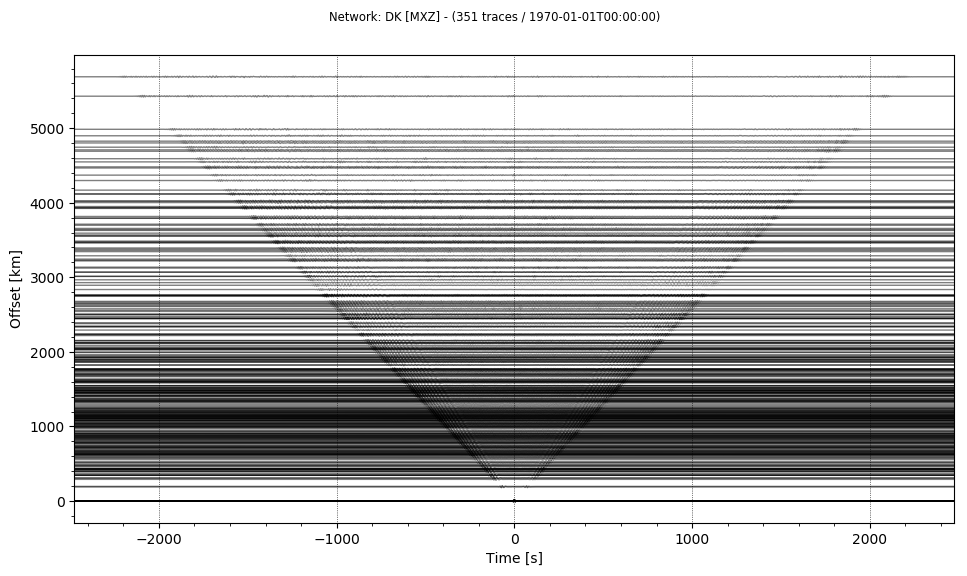

In [14]:
# plot correlations and save the file
corr_homo_path = os.path.join(source_homo_path,"step_0/corr")

# make azimuth selection
traces_homo =plot_section(corr_homo_path,stationlist_path,bandpass = None,comp = 'BHZ',fmt = 'SAC',az_selection = [0,180], 
                      scale = 1., resol = 1,plot=False)

#plot
maxlag = (traces_homo[0].stats.npts-1) / 2.0

traces_homo.plot(type='section',orientation='horizontal',
reftime = traces_homo[0].stats.starttime + maxlag,scale=1.)
plt.show()

traces_homo.plot(type='section',orientation='horizontal',
reftime = traces_homo[0].stats.starttime + maxlag,scale=1.,outfile=os.path.join(project_path,'homo_correlations.png'))


In [19]:
# Setup the Data Source

# Setup a homogeneous source called homo_source
source_data = "data_source"

source_data_path = os.path.join(project_path,source_data)
os.system ('noisi setup_source ' + source_data_path)


print('New source created: ', source_data_path)

Changed directory to: /Users/jigel/noisi/TEST_Project
New source created:  /Users/jigel/noisi/TEST_Project/data_source


In [16]:
# Change source_config file
source_config_path = os.path.join(source_data_path,'source_config.json')

with io.open(source_config_path,'r+') as fh:
        conf = json.loads(fh.read())

# change instaseis and wavefield
conf['max_lag'] = 2500
conf['preprocess_do'] = False
conf ['project_name'] = project_name
conf ['project_path'] = project_path
with io.open(source_config_path,'w') as fh:
    cf = json.dumps(conf,sort_keys=False, indent=4, separators=(",", ": "))
    fh.write(cf)

Number of gridpoints:  13861


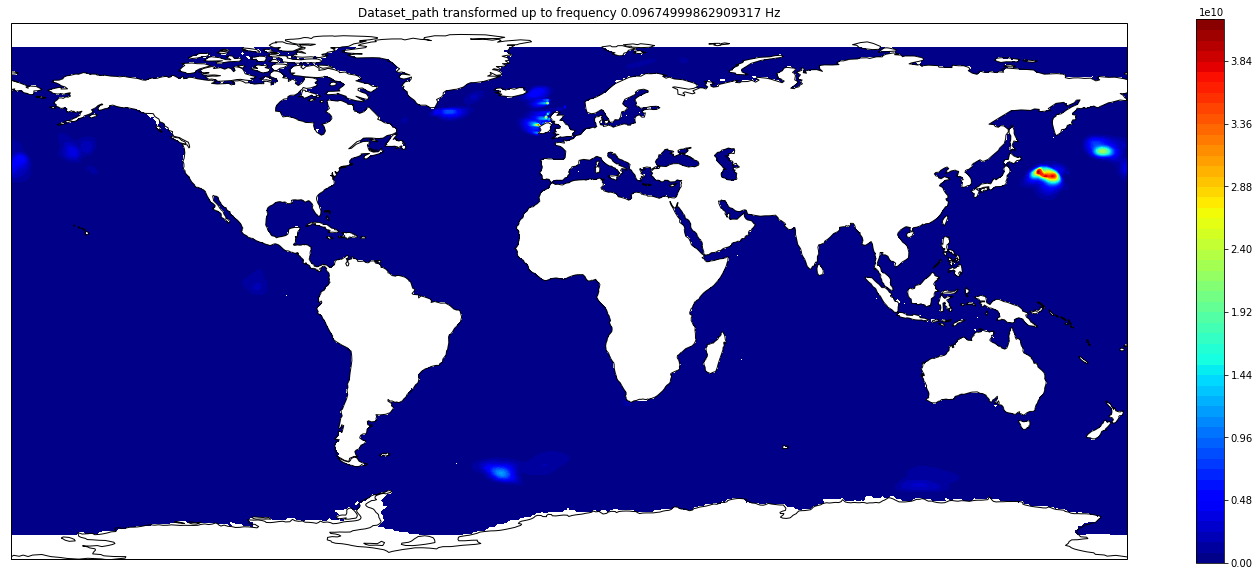

<HDF5 file "UP.ROTU..MXZ.h5" (mode r)>
df = 1.0 nt =  4953 n =  10000
freq_min =  0.0 freq_max =  0.5
Getting ocean mask...
Latitude from -88.0 to 88.0,
        Longitude from -180.0 to 180.0
Sampling grid...
At Gridpoint:  0
At Gridpoint:  1000
At Gridpoint:  2000
At Gridpoint:  3000
At Gridpoint:  4000
At Gridpoint:  5000
At Gridpoint:  6000
At Gridpoint:  7000
At Gridpoint:  8000
At Gridpoint:  9000
At Gridpoint:  10000
At Gridpoint:  11000
At Gridpoint:  12000
At Gridpoint:  13000
Done.


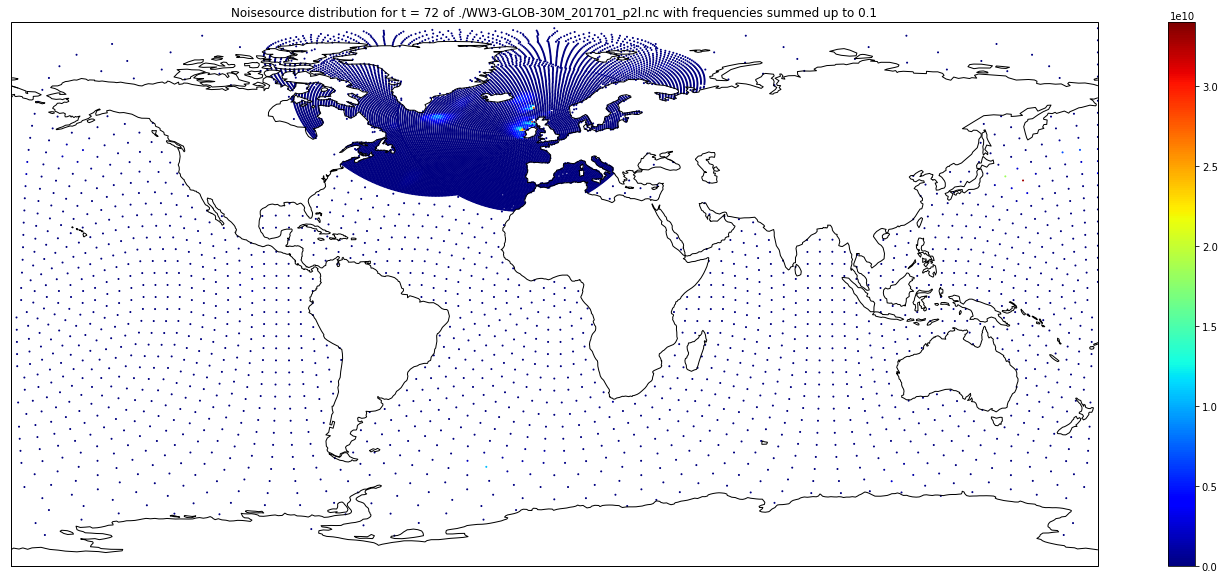

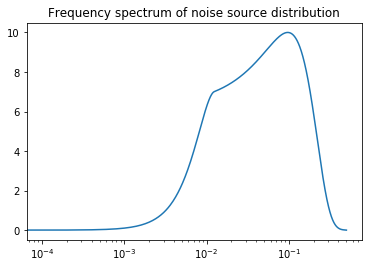

Number of grids:  5
Grid 1 of 5
Grid 2 of 5
Grid 3 of 5
Grid 4 of 5
Grid 5 of 5
0 of 21553 voronoi cell surface areas calculated.
1000 of 21553 voronoi cell surface areas calculated.
2000 of 21553 voronoi cell surface areas calculated.
3000 of 21553 voronoi cell surface areas calculated.
4000 of 21553 voronoi cell surface areas calculated.
5000 of 21553 voronoi cell surface areas calculated.
6000 of 21553 voronoi cell surface areas calculated.
7000 of 21553 voronoi cell surface areas calculated.
8000 of 21553 voronoi cell surface areas calculated.
9000 of 21553 voronoi cell surface areas calculated.
10000 of 21553 voronoi cell surface areas calculated.
11000 of 21553 voronoi cell surface areas calculated.
12000 of 21553 voronoi cell surface areas calculated.
13000 of 21553 voronoi cell surface areas calculated.
14000 of 21553 voronoi cell surface areas calculated.
15000 of 21553 voronoi cell surface areas calculated.
16000 of 21553 voronoi cell surface areas calculated.
17000 of 21553 

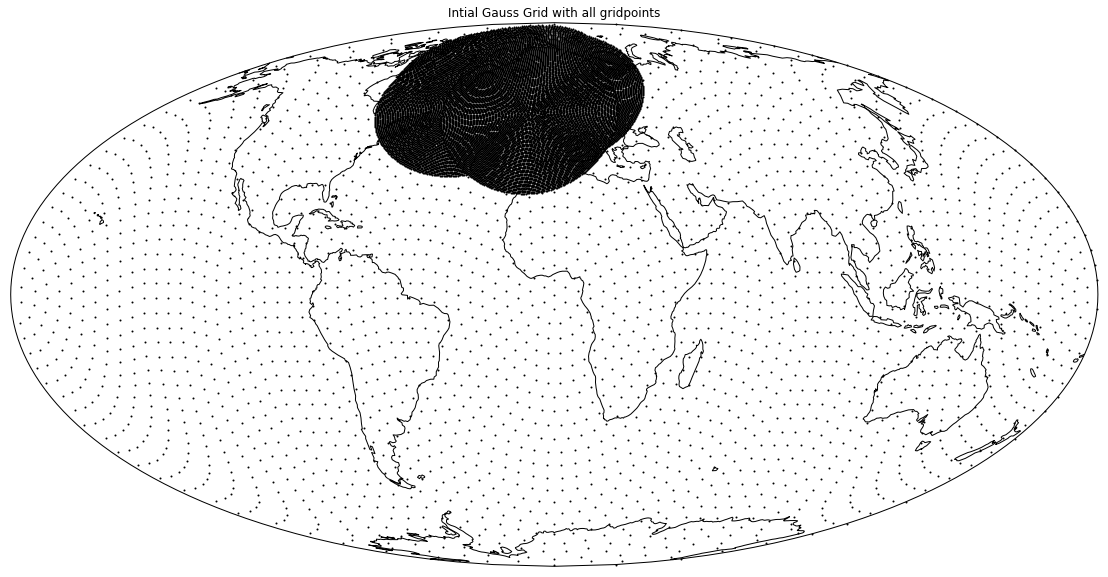

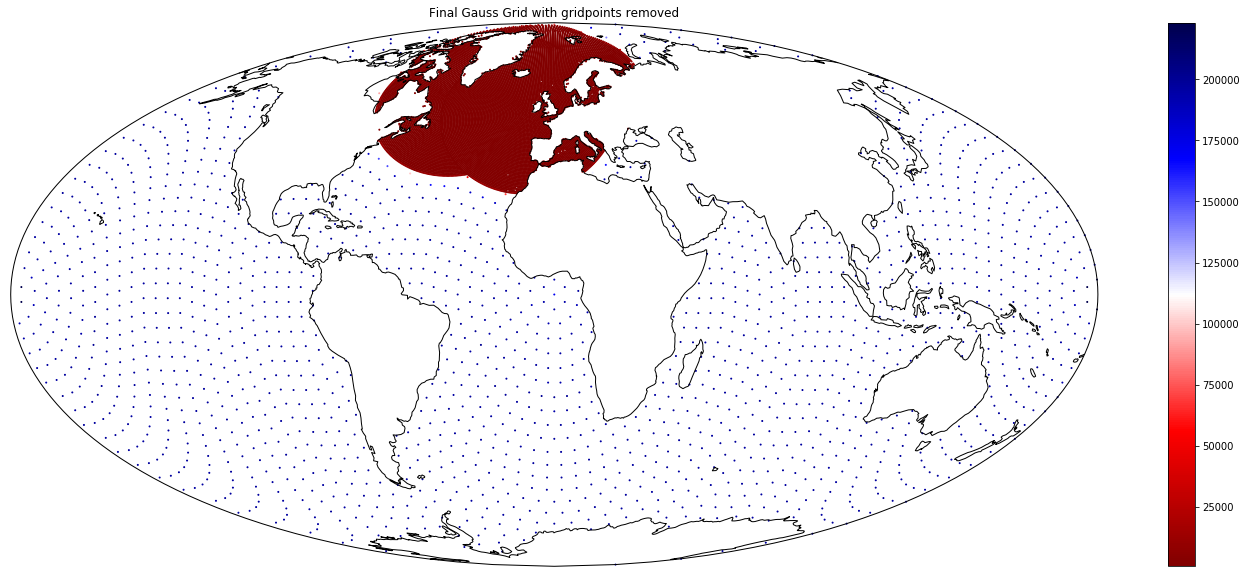

Gridpoints and voronoi cells on land removed.
Final number of gridpoints: 13861


In [17]:
# Setup noise source with data
setup_noisesource_new(project_path,source_data_path,data_path = data_path, t_data = t_data, f_dom = f_dom,outfile=True)

# save file with noise source distribution

In [18]:
# calculate correlations for homogeneous source
print("Computing correlations...")
os.system("mpirun -np {} noisi correlation {} {}".format(n_cores,source_data_path,0))
print("All correlations computed.")

Computing correlations...
All correlations computed.


/Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr
Found traces:

/Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/GB.CWF..MXZ--GE.VAL..MXZ.sac
...to...
/Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/DK.MUD..MXZ--NS.FOO..MXZ.sac
Assign geographical information.

CWF VAL
52.7383 -1.30722 51.9394 -10.2442
UDBI UDBI
44.5279 15.7644 44.5279 15.7644
BIGH CWF
58.4933 -3.9105 52.7383 -1.30722
FRB SFJD
63.7469 -68.5451 66.9961 -50.62076
DRUM CLL
56.9126 -2.4865 51.30769 13.00261
CWF SOFL
52.7383 -1.30722 62.0689 -6.9658
MONQ VAL
44.3676 1.1953 51.9394 -10.2442
GIMEL BSEG
46.533640000000005 6.26545 53.93531 10.316889999999999
FUORN BIGH
46.62022 10.26352 58.4933 -3.9105
UDBI ISKR
44.5279 15.7644 64.559998 -18.385998999999998
FUORN FUORN
46.62022 10.26352 46.62022 10.26352
SFJD FOO
66.9961 -50.62076 61.598 5.044
CLF CLL
48.02581 2.26 51.30769 13.00261
FOO NSS
61.598 5.044 64.53 11.967
SOFL ISKR
62.0689 -6.9658 64.559998 -18.385998999999998
GIMEL

63.7469 -68.5451 48.1655 11.27633
MONQ JMIC
44.3676 1.1953 70.9866 -8.5057
EKSU EKSU
57.5726 15.3016 57.5726 15.3016
MUD VAL
56.455 9.17331 51.9394 -10.2442
CLL JMIC
51.30769 13.00261 70.9866 -8.5057
GIMEL SOFL
46.533640000000005 6.26545 62.0689 -6.9658
CWF BSEG
52.7383 -1.30722 53.93531 10.316889999999999
CLL EKSU
51.30769 13.00261 57.5726 15.3016
SOFL VAL
62.0689 -6.9658 51.9394 -10.2442
CWF SFJD
52.7383 -1.30722 66.9961 -50.62076
FRB CWF
63.7469 -68.5451 52.7383 -1.30722
GIMEL CLF
46.533640000000005 6.26545 48.02581 2.26
UDBI FOO
44.5279 15.7644 61.598 5.044
IVI ISKR
61.205808 -48.171178000000005 64.559998 -18.385998999999998
FRB SOFL
63.7469 -68.5451 62.0689 -6.9658
VAL CLL
51.9394 -10.2442 51.30769 13.00261
FUORN MUD
46.62022 10.26352 56.455 9.17331
FUORN JSA
46.62022 10.26352 49.1879 -2.17089
SFJD SFJD
66.9961 -50.62076 66.9961 -50.62076
FUORN CLL
46.62022 10.26352 51.30769 13.00261
SOFL FUR
62.0689 -6.9658 48.1655 11.27633
CMSN EKSU
40.8382 14.1818 57.5726 15.3016
UDBI IVI
44.52

Trace changed from UDBI--UDBI to UDBI--UDBI.
Trace changed from BIGH--CWF to CWF--BIGH.
Trace changed from FRB--SFJD to SFJD--FRB.
Trace changed from DRUM--CLL to CLL--DRUM.
Trace changed from GIMEL--BSEG to BSEG--GIMEL.
Trace changed from FUORN--FUORN to FUORN--FUORN.
Trace changed from SFJD--FOO to FOO--SFJD.
Trace changed from CLF--CLL to CLL--CLF.
Trace changed from FOO--NSS to NSS--FOO.
Trace changed from GIMEL--TNS to TNS--GIMEL.
Trace changed from GIMEL--NSS to NSS--GIMEL.
Trace changed from CWF--FUR to FUR--CWF.
Trace changed from DRUM--JSA to JSA--DRUM.
Trace changed from MONQ--FUR to FUR--MONQ.
Trace changed from CWF--CWF to CWF--CWF.
Trace changed from DRUM--EKSU to EKSU--DRUM.
Trace changed from VAL--EKSU to EKSU--VAL.
Trace changed from FUR--EKSU to EKSU--FUR.
Trace changed from BSEG--BSEG to BSEG--BSEG.
Trace changed from SFJD--NSS to NSS--SFJD.
Trace changed from CLF--CMSN to CMSN--CLF.
Trace changed from VAL--JMIC to JMIC--VAL.
Trace changed from CWF--CLF to CLF--CWF.
T

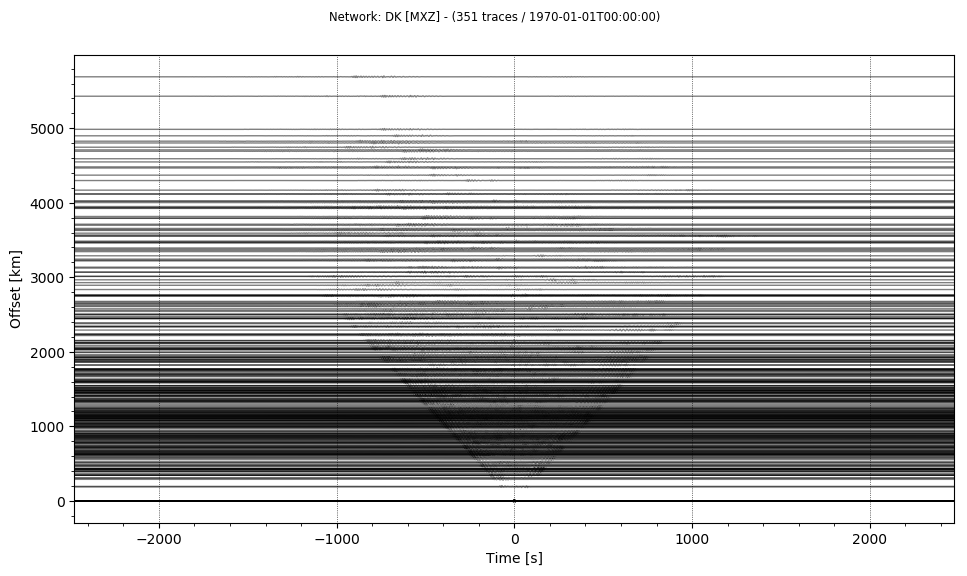

In [19]:
# plot correlations and save the file
corr_data_path = os.path.join(source_data_path,"step_0/corr")

# make azimuth selection
traces_data =plot_section(corr_data_path,stationlist_path,bandpass = None,comp = 'BHZ',fmt = 'SAC',az_selection = [0,180], 
                      scale = 1., resol = 1,plot=False)

#plot
maxlag = (traces_data[0].stats.npts-1) / 2.0

traces_data.plot(type='section',orientation='horizontal', reftime = traces_data[0].stats.starttime + maxlag,scale=1.)
plt.show()

traces_data.plot(type='section',orientation='horizontal', reftime = traces_data[0].stats.starttime + maxlag,scale=1.,outfile=os.path.join(project_path,'data_correlations.png'))



In [20]:
# copy correlations to observed correlations in homo_source
corr_obs_path = os.path.join(source_homo_path,"observed_correlations")

for files in glob(os.path.join(corr_data_path,'*.sac')):
        shutil.copy(files,corr_obs_path)
        print('Copied:',files)

# make synthetic data
make_synth_data(project_name,stationlist_path,corr_obs_path)
print('Synthetic data created.')

Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/GB.CWF..MXZ--GE.VAL..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CR.UDBI..MXZ--CR.UDBI..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/GB.BIGH..MXZ--GB.CWF..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CN.FRB..MXZ--IU.SFJD..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/GB.DRUM..MXZ--GR.CLL..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/GB.CWF..MXZ--GB.SOFL..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/FR.MONQ..MXZ--GE.VAL..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CH.GIMEL..MXZ--GR.BSEG..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CH.FUORN..MXZ--GB.BIGH..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_sourc

Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CH.GIMEL..MXZ--G.CLF..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CR.UDBI..MXZ--NS.FOO..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/G.IVI..MXZ--VI.ISKR..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CN.FRB..MXZ--GB.SOFL..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/GE.VAL..MXZ--GR.CLL..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CH.FUORN..MXZ--DK.MUD..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CH.FUORN..MXZ--GB.JSA..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/IU.SFJD..MXZ--IU.SFJD..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/step_0/corr/CH.FUORN..MXZ--GR.CLL..MXZ.sac
Copied: /Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/data_source/

/Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/homo_source/observed_correlations
Found traces:

/Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/homo_source/observed_correlations/CN.FRB..MXZ.GB.JSA..MXZ.Fabrice_10s_ALPHA_TEST.sac
...to...
/Users/jigel/noisi/Fabrice_10s_ALPHA_TEST/homo_source/observed_correlations/CN.FRB..MXZ.DK.MUD..MXZ.Fabrice_10s_ALPHA_TEST.sac


Assign geographical information.

Number of traces:
351


FRB JSA
63.7469 -68.5451 49.1879 -2.17089
JSA JSA
49.1879 -2.17089 49.1879 -2.17089
BIGH CLL
58.4933 -3.9105 51.30769 13.00261
FUORN CWF
46.62022 10.26352 52.7383 -1.30722
CLF ROTU
48.02581 2.26 61.42 15.814
SOFL IVI
62.0689 -6.9658 61.205808 -48.171178000000005
IVI FUR
61.205808 -48.171178000000005 48.1655 11.27633
UDBI FOO
44.5279 15.7644 61.598 5.044
GIMEL CWF
46.533640000000005 6.26545 52.7383 -1.30722
DRUM JMIC
56.9126 -2.4865 70.9866 -8.5057
CWF JMIC
52.7383 -1.30722 70.9866 -8.5057
GIMEL SFJD
46.533640000000005 6.26545 66.9961 -50.62076
FRB UDBI
63.7469 -68.5451 44.5279 15

61.205808 -48.171178000000005 61.42 15.814
FRB FRB
63.7469 -68.5451 63.7469 -68.5451
MONQ JMIC
44.3676 1.1953 70.9866 -8.5057
DRUM TNS
56.9126 -2.4865 50.2225 8.44731
SOFL EKSU
62.0689 -6.9658 57.5726 15.3016
CLF CLL
48.02581 2.26 51.30769 13.00261
VAL IVI
51.9394 -10.2442 61.205808 -48.171178000000005
MONQ FOO
44.3676 1.1953 61.598 5.044
DRUM JSA
56.9126 -2.4865 49.1879 -2.17089
GIMEL IVI
46.533640000000005 6.26545 61.205808 -48.171178000000005
VAL EKSU
51.9394 -10.2442 57.5726 15.3016
IVI EKSU
61.205808 -48.171178000000005 57.5726 15.3016
SOFL FOO
62.0689 -6.9658 61.598 5.044
FUORN ISKR
46.62022 10.26352 64.559998 -18.385998999999998
BIGH SFJD
58.4933 -3.9105 66.9961 -50.62076
NSS NSS
64.53 11.967 64.53 11.967
UDBI ROTU
44.5279 15.7644 61.42 15.814
SFJD SFJD
66.9961 -50.62076 66.9961 -50.62076
FUR CMSN
48.1655 11.27633 40.8382 14.1818
BIGH TNS
58.4933 -3.9105 50.2225 8.44731
BSEG JMIC
53.93531 10.316889999999999 70.9866 -8.5057
MONQ ISKR
44.3676 1.1953 64.559998 -18.385998999999998
G

In [21]:
# noisi measurement
print('Computing adjoint sources...')
os.system('noisi measurement {} {}'.format(source_homo_path,0))
print('Done.')

Computing adjoint sources...
Done.


In [22]:
# Compute kernels
print('Computing kernels...')
os.system('mpirun -np {} noisi kernel {} {}'.format(n_cores,source_homo_path,0))
print('Done.')

Computing kernels...
Done.


In [23]:
# Compute gradient
print('Computing gradient...')
os.system('noisi gradient {} {}'.format(source_homo_path,0))
print('Done.')

Computing gradient...
Done.


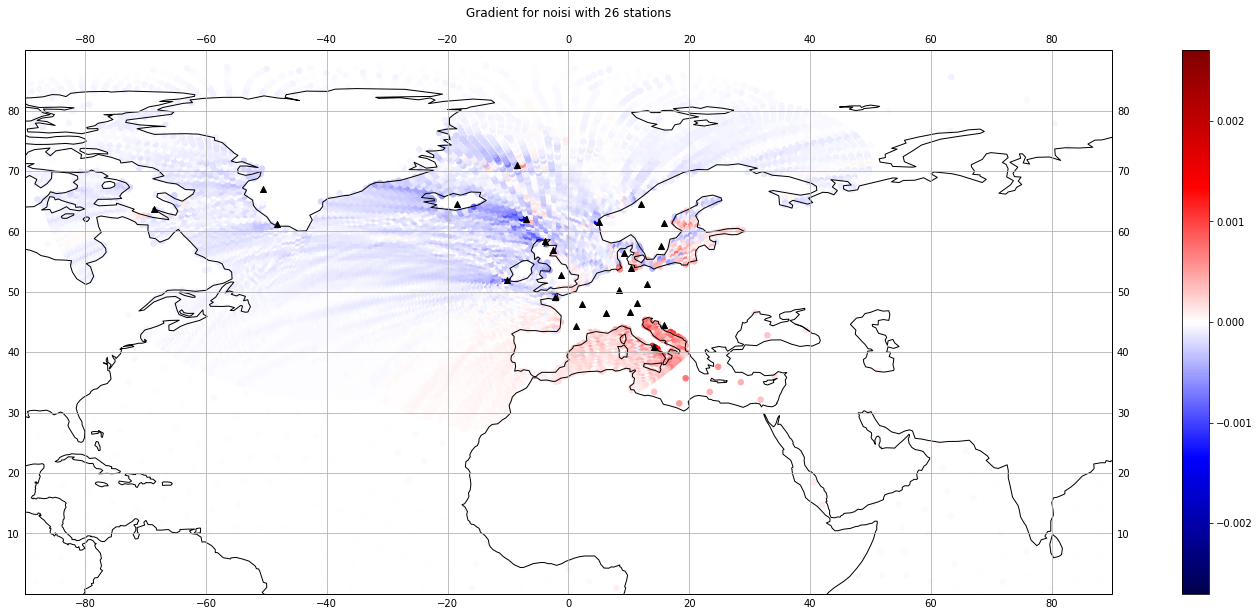

In [26]:
# Plot Gradient
plot_gradient(project_path,source_homo_path,extent=extent,gridlines = True)
# save file
plt.savefig(os.path.join(project_path,"data_gradient.png"))



In [23]:
# Go back to main directory
os.chdir(main_path)
print('Directory changed to:',os.getcwd())

Directory changed to: /Users/jigel/noisi
